In [19]:
import warnings

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

from src.features import utils, build_features_final, build_features
from src.models import predict_model
from src.train.train import train, evaluation, prediction_to_csv
from src.data.make_dataset import DatasetLoader
from src.visualization.visual import anomaly_plot
from src.config.config import seed_everything, cfg

warnings.filterwarnings(action='ignore')
seed_everything(cfg.SEED)

scaler = MinMaxScaler()

train_data = pd.read_csv(r'data\raw\train_data.csv')
add_train = pd.read_csv(r'data\processed\robust.csv')
# train_data = utils.outlier_z_score_filter_df(train_data, threshold=3)
train_data = pd.concat([train_data, add_train], axis=0)
train_data = build_features_final.create_derived_features(train_data)

test_data = pd.read_csv(r'data\raw\test_data.csv')
test_data = build_features_final.create_derived_features(test_data)


grouped_train = train_data.groupby('type')

drop_feature = ['type', 'motor_hp', 'air_end_temp', 'motor_rpm', 'motor_temp', 'motor_vibe', 'motor_current',
                'air_inflow', "air_flow_pressure", "current_by_vibration", "airflow_per_rotation", 'volumetric_efficiency',
                'air_to_motor_ratio']

# drop_feature = ['type', 'motor_hp', "air_flow_pressure", "current_by_vibration", "airflow_per_rotation", 'volumetric_efficiency', 'air_to_motor_ratio']

anomaly = []
all_threshold = []
for group_name, group_data in grouped_train:
    test_group = test_data[test_data['type'] == group_name]
    train_group = group_data.drop(drop_feature, axis=1).values
    test_group = test_group.drop(drop_feature, axis=1).values

    train_group = scaler.fit_transform(train_group)
    test_group = scaler.transform(test_group)
    
    print(f'train size: {train_group.shape}')
    n_features = train_group.shape[1]
    dataloader = DatasetLoader(train_group, test_group)
    train_loader, test_loader = dataloader.load
    
    model = predict_model.SingleAutoEncoder(n_features, 512)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    train(train_loader, model, criterion, optimizer)

    train_prediction, train_threshold = evaluation(train_loader, model)
    test_prediction, test_threshold = evaluation(test_loader, model, min(train_threshold))

    anomaly.append(test_prediction)
    all_threshold.append(test_threshold)
    print(f"finish {group_name}type")

all_threshold = np.concatenate(all_threshold)
anomaly = np.concatenate(anomaly)
submission = prediction_to_csv(anomaly)

train size: (1580, 9)
Epoch [0/1000], Loss: 0.1293069
Epoch [100/1000], Loss: 0.0000051
Epoch [200/1000], Loss: 0.0000022
Epoch [300/1000], Loss: 0.0000017
Epoch [400/1000], Loss: 0.0000017
Epoch [500/1000], Loss: 0.0000013
Epoch [600/1000], Loss: 0.0000012
Epoch [700/1000], Loss: 0.0000015
Epoch [800/1000], Loss: 0.0000009
Epoch [900/1000], Loss: 0.0000078
finish 0type
train size: (1124, 9)
Epoch [0/1000], Loss: 0.2850362
Epoch [100/1000], Loss: 0.0000026
Epoch [200/1000], Loss: 0.0000010
Epoch [300/1000], Loss: 0.0000006
Epoch [400/1000], Loss: 0.0000004
Epoch [500/1000], Loss: 0.0000003
Epoch [600/1000], Loss: 0.0000003
Epoch [700/1000], Loss: 0.0000002
Epoch [800/1000], Loss: 0.0000002
Epoch [900/1000], Loss: 0.0000003
finish 1type
train size: (571, 9)
Epoch [0/1000], Loss: 0.1721931
Epoch [100/1000], Loss: 0.0000061
Epoch [200/1000], Loss: 0.0000018
Epoch [300/1000], Loss: 0.0000012
Epoch [400/1000], Loss: 0.0000009
Epoch [500/1000], Loss: 0.0000008
Epoch [600/1000], Loss: 0.00000

In [20]:
test_data['label'] = anomaly
test_data['treshold'] = all_threshold
def no_out(test_data):
    test7342 = test_data[7342:7361]
    no = test7342[test7342['label']==1]
    yes = test7342[test7342['label']==0]
    return yes, no
yes, no = no_out(test_data)

Chunk 0: 144/1296 labels with value 1


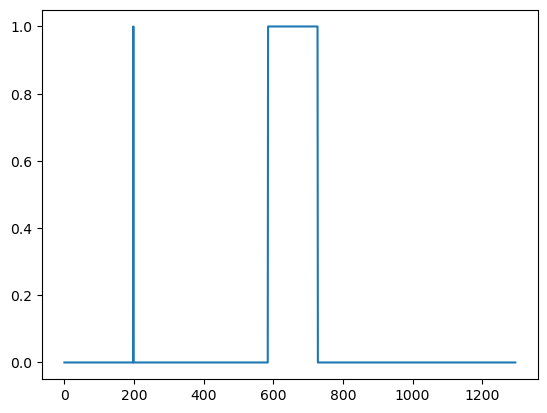

Chunk 1: 0/1107 labels with value 1


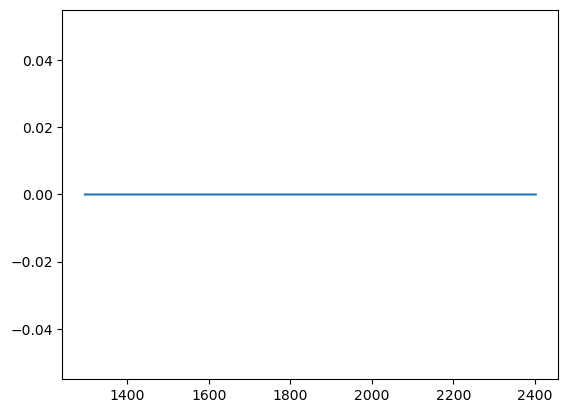

Chunk 2: 30/1098 labels with value 1


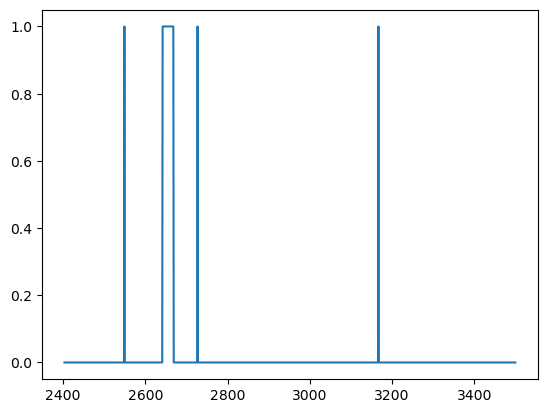

Chunk 3: 34/918 labels with value 1


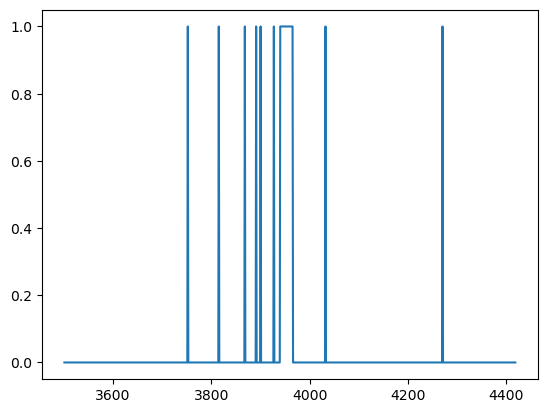

Chunk 4: 14/918 labels with value 1


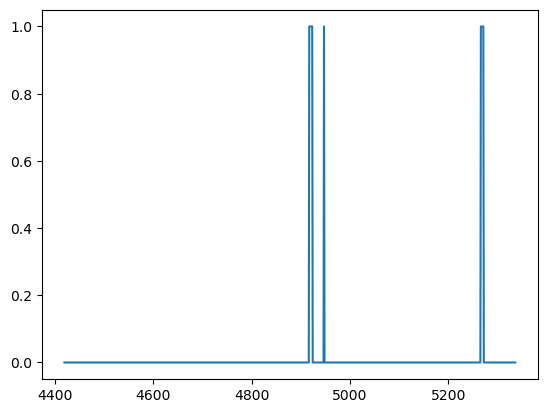

Chunk 5: 30/746 labels with value 1


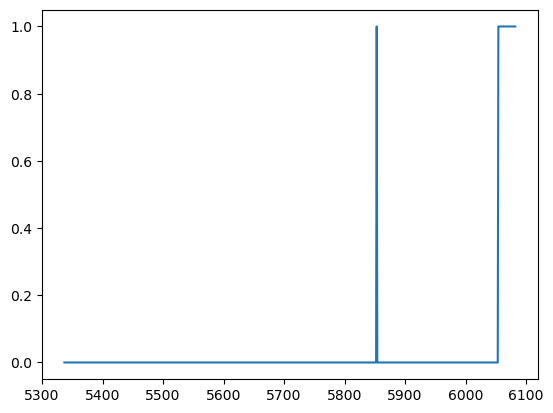

Chunk 6: 102/748 labels with value 1


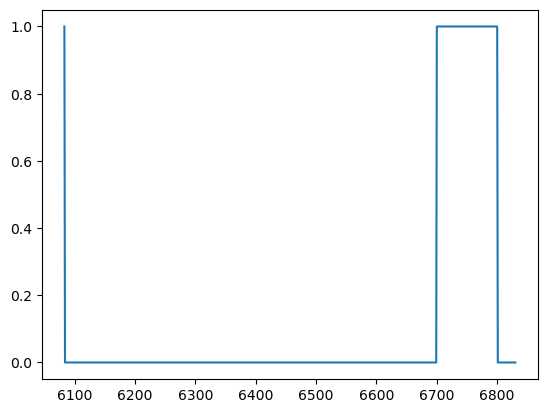

Chunk 7: 5/558 labels with value 1


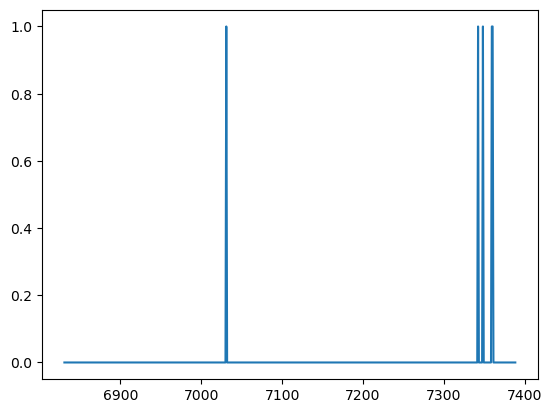

In [21]:
def plot_label_counts(predictions, chunk_sizes):
    for i, (start, end) in enumerate(chunk_sizes):
        chunk = predictions[start:end]
        num_labels = len(chunk[chunk['label'] == 1])
        print(f"Chunk {i}: {num_labels}/{len(chunk)} labels with value 1")
        plt.plot(chunk['label'])
        plt.show()
ranges = [(0, 1296), (1296, 2403), (2403, 3501), (3501, 4419), (4419, 5337), (5337, 6083), (6083, 6831), (6831, len(anomaly))]
plot_label_counts(submission, ranges)